In [48]:
import nltk
nltk.download('wordnet', force=True)
nltk.download('sentiwordnet', force=True)
from nltk.corpus import sentiwordnet as swn
from textblob import TextBlob
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ishathukral/nltk_data...
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/ishathukral/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ishathukral/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
vocab_df = pd.read_csv('/Users/ishathukral/Downloads/DS5001project/output/VOCAB.csv', sep='|')

# Define a function to get sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply function to get sentiment polarity and subjectivity
vocab_df[['sentiment_polarity', 'sentiment_subjectivity']] = vocab_df['term_str'].apply(
    lambda x: pd.Series(get_sentiment(x))
)

In [7]:
# Save the enriched vocabulary table
vocab_df.to_csv('/Users/ishathukral/Downloads/DS5001project/output/VOCAB_SENT.csv', sep='|', index=False)

In [9]:
vocab_sent_df = pd.read_csv('/Users/ishathukral/Downloads/DS5001project/output/VOCAB_SENT.csv', sep='|')

# Display the first few rows of the dataframe to see the sentiment scores
vocab_sent_df.head()

,term_str,n,df,idf,dfidf,porter_stem,max_pos,stop,sentiment_polarity,sentiment_subjectivity
0,",",71015,120,1.546544,185.585245,",",",",False,0.0,0.0
1,.,53951,2,5.243722,10.487444,.,.,False,0.0,0.0
2,lord,18346,11,3.857428,42.431704,lord,NN,False,0.0,0.0
3,;,13573,9,4.039749,36.357742,;,:,False,0.0,0.0
4,1,6615,9,4.039749,36.357742,1,CD,False,0.0,0.0


In [17]:

bow_df = pd.read_csv('/Users/ishathukral/Downloads/DS5001project/output/BOW.csv', sep='|')  # Replace with your actual path

vocab_sent_df.rename(columns={'sentiment_polarity': 'sentiment_score'}, inplace=True)

bow_sent_df = bow_df.merge(vocab_sent_df[['term_str', 'sentiment_score']], on='term_str', how='left')

# Calculate the weighted sentiment score for each term in each document
bow_sent_df['weighted_sentiment'] = bow_sent_df['n'] * bow_sent_df['sentiment_score']

# Aggregate these weighted sentiment scores at the document level to get the total sentiment per document
doc_sentiment = bow_sent_df.groupby('doc_id')['weighted_sentiment'].sum().reset_index()

# Merge the aggregated document sentiment back into the BOW DataFrame
bow_df = bow_df.merge(doc_sentiment, on='doc_id', how='left')

bow_df

,doc_id,term_str,n,document_frequency,idf,tf,tfidf,weighted_sentiment
0,1,!,19,120,1.005522,0.003689,0.003710,79.977489
1,1,(,1,9,3.182673,0.000194,0.000618,79.977489
2,1,),1,9,3.182673,0.000194,0.000618,79.977489
3,1,",",367,208,0.693147,0.071262,0.049395,79.977489
4,1,.,350,208,0.693147,0.067961,0.047107,79.977489
...,...,...,...,...,...,...,...,...
134099,208,women,2,34,1.962577,0.004040,0.007930,1.100000
134100,208,||,21,208,0.693147,0.042424,0.029406,1.100000
134101,208,óóóóóóóóó,1,182,0.762140,0.002020,0.001540,1.100000
134102,208,óóóóóóóóóóó,1,182,0.762140,0.002020,0.001540,1.100000


In [19]:
bow_df.to_csv('/Users/ishathukral/Downloads/DS5001project/output/BOW_SENT.csv', sep='|', index=False)

In [22]:

bow_sent_df = pd.read_csv('/Users/ishathukral/Downloads/DS5001project/output/BOW_SENT.csv', sep='|')

# Compute sentiment for each document
# This assumes you have a column 'sentiment_value' in bow_sent_df
doc_sentiment = bow_sent_df.groupby('doc_id')['weighted_sentiment'].mean()  # or sum(), depending on your need

# Create DOC_SENT DataFrame
doc_sent_df = doc_sentiment.reset_index()
doc_sent_df.columns = ['doc_id', 'doc_sentiment']

# Print the first few rows to verify
doc_sent_df.head()


,doc_id,doc_sentiment
0,1,79.977489
1,2,17.119697
2,3,0.450000
3,4,5.953571
4,5,1.500000


In [26]:
# List of ragas and their start pages
ragas = {
    "Asa": 8, "Gujari": 10, "Gauri Deepaki": 12, "Dhanasri": 13, "Gauri Poorabi": 13, "Sri": 14, 
    "Majh": 94, "Gauri Guarairee": 151, "Gauri": 151, "Gauri Dakhani": 152, "Gauri Chaitee": 154, 
    "Gauri Bairagan": 155, "Gauri Poorabi Deepaki": 157, "Gauri Majh": 172, "Gauri Malva": 214, 
    "Gauri Mala": 214, "Gauri Sorath": 330, "Asa Kafi": 365, "Asavari": 369, "Asa Asavari": 409, 
    "Devgandhari": 527, "Bihagra": 537, "Vadhans": 557, "Vadhans Dakhani": 580, "Sorath": 595, 
    "Jaitsri": 696, "Todi": 711, "Bairarri": 719, "Tilang": 721, "Tilang Kafi": 726, "Suhee": 728, 
    "Suhee Kafi": 751, "Suhee Lalit": 793, "Bilaval": 795, "Bilaval Dakhani": 843, "Gound": 859, 
    "Bilaval Gound": 874, "Ramkali": 876, "Ramkali Dakhani": 907, "Nut Narayan": 975, "Nut": 975, 
    "Mali Gaura": 984, "Maru": 989, "Maru Kafi": 1014, "Maru Dakhani": 1033, "Tukhari": 1107, 
    "Kedara": 1118, "Bhairo": 1125, "Basant": 1168, "Basant Hindol": 1170, "Sarang": 1197, 
    "Malar": 1254, "Kanra": 1294, "Kaliyan": 1319, "Kaliyan Bhopali": 1321, "Parbhati Bibhas": 1327, 
    "Parbhati": 1327, "Parbhati Dakhani": 1344, "Bibhas Parbhati": 1347, "Jaijavanti": 1352
}

# Convert dictionary to DataFrame
raga_df = pd.DataFrame(list(ragas.items()), columns=['Raga', 'Start_Page'])

# Calculate end page of each raga (assuming the end page is the start of the next raga minus one)
raga_df['End_Page'] = raga_df['Start_Page'].shift(-1) - 1
raga_df.at[len(raga_df)-1, 'End_Page'] = 1430  # Assuming 1430 is the last page of the Guru Granth Sahib

# Display the DataFrame
raga_df.head()


,Raga,Start_Page,End_Page
0,Asa,8,9.0
1,Gujari,10,11.0
2,Gauri Deepaki,12,12.0
3,Dhanasri,13,12.0
4,Gauri Poorabi,13,13.0


In [27]:
raga_df.to_csv('/Users/ishathukral/Downloads/DS5001project/output/raga_pages.csv', index=False)

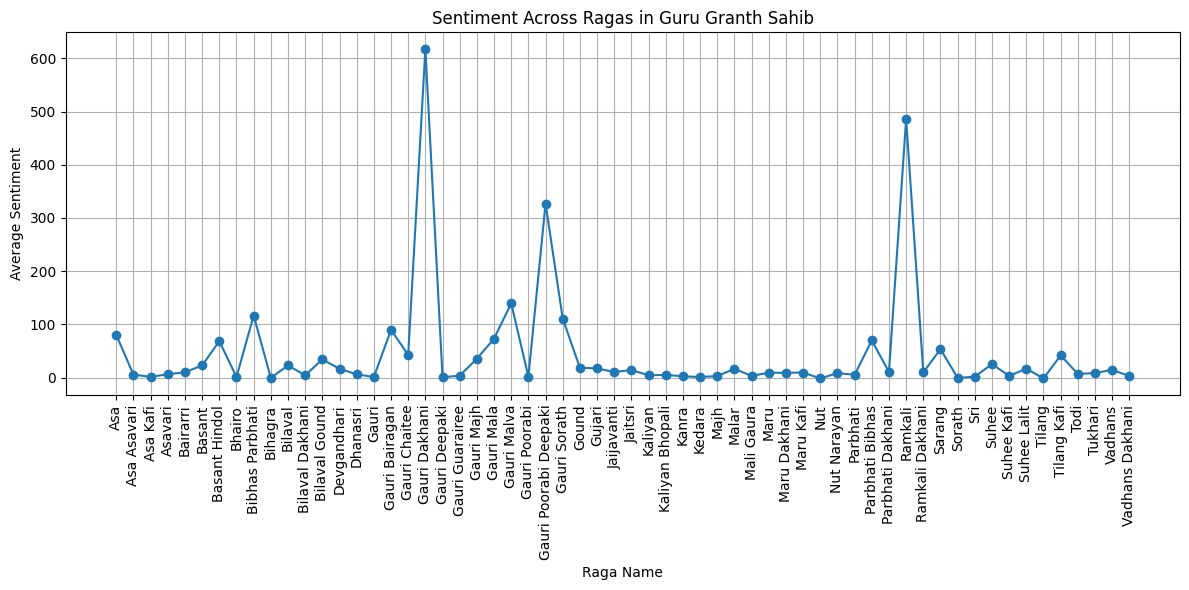

In [30]:


# Load or assume the presence of DataFrames
# doc_sent_df = pd.read_csv('path/to/your/doc_sentiment.csv')
# raga_df = pd.read_csv('path/to/your/raga_pages.csv')

# Create a dummy example if raga_df does not have doc_id
raga_df['doc_id'] = range(1, len(raga_df) + 1)  # This is a placeholder

# Merge sentiment data with raga information based on a meaningful association
# Assuming `raga_df` has a direct or indirect association with `doc_id`
# Here, the association needs to be defined. This might be a direct merge if doc_id can be matched or require computation.
# Example assumes direct match for simplicity.
sentiment_raga_df = pd.merge(doc_sent_df, raga_df, on='doc_id')
sentiment_raga_df = sentiment_raga_df.groupby('Raga')['doc_sentiment'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(sentiment_raga_df['Raga'], sentiment_raga_df['doc_sentiment'], marker='o', linestyle='-')
plt.title('Sentiment Across Ragas in Guru Granth Sahib')
plt.xlabel('Raga Name')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


In [42]:
CORPUS = pd.read_csv('/Users/ishathukral/Downloads/DS5001project/output/CORPUS.csv', delimiter='|')
VOCAB = pd.read_csv('/Users/ishathukral/Downloads/DS5001project/output/VOCAB.csv', delimiter='|')

In [44]:

# Aggregate tokens into documents
CORPUS['token_str'] = CORPUS['token_str'].astype(str)  # Ensure all tokens are strings
documents = CORPUS.groupby('doc_id')['token_str'].apply(list).tolist()

# Train a Word2Vec model
model = Word2Vec(sentences=documents, vector_size=100, window=5, min_count=2, workers=4)

# Extract word vectors for terms in the vocab
vocab_words = VOCAB['term_str'].tolist()
word_vectors = {word: model.wv[word] for word in vocab_words if word in model.wv}

# Convert to DataFrame
vocab_w2v_df = pd.DataFrame.from_dict(word_vectors, orient='index')

vocab_w2v_df


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
",",-0.450436,0.184590,0.217211,1.334254,-0.894624,0.388101,0.375264,-0.719834,-0.385857,-0.085321,...,1.655695,-0.547898,0.750559,-0.169514,0.359119,0.115740,0.439012,-0.428805,-0.848156,-0.285856
.,-0.636264,1.329412,-1.643402,1.438261,0.317792,0.228316,-0.954769,0.862145,-0.163001,0.555395,...,1.373371,0.114286,0.484366,-0.337199,1.104557,0.654239,1.274175,-1.022296,0.516352,-0.290708
lord,-0.016257,0.052094,0.001607,-0.041246,-0.007370,-0.042935,-0.002857,0.055964,0.021778,0.031156,...,-0.016766,-0.009816,-0.022376,-0.007228,0.006435,0.017460,0.000505,-0.026313,0.020572,-0.004893
;,-1.061243,1.609937,1.220508,0.897706,-1.707320,1.403073,-0.925821,-2.006797,-1.872356,2.147086,...,0.887741,-0.454320,0.719389,-0.887031,-0.357972,-0.555656,0.181548,-0.948875,1.565301,-0.031339
1,1.065468,-0.695033,-3.856155,2.294497,-0.365722,-1.295205,0.555943,2.482215,-3.447201,-1.110718,...,0.308354,-0.491160,1.124937,1.778080,-0.181627,-0.587222,-0.651781,0.445679,-0.714883,-0.506827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
helps,-0.012526,0.019425,-0.022977,0.028785,-0.010928,-0.025081,0.006360,-0.000109,-0.023092,-0.020556,...,-0.009206,-0.031047,0.010775,-0.011789,0.013607,0.005497,0.006456,0.008378,0.037527,-0.016956
sugarcane,-0.003170,0.014662,0.010894,-0.003542,0.005327,-0.018643,-0.013135,0.026748,-0.003457,0.009650,...,-0.008756,0.008513,-0.015928,-0.005319,0.012310,0.011141,0.012086,-0.035455,0.006550,0.004951
lament,0.015489,-0.004503,0.002324,-0.015349,0.003987,-0.005195,-0.036110,0.004843,0.003313,-0.005886,...,0.009387,-0.007349,-0.010253,-0.000667,-0.013007,0.027904,-0.000836,-0.001924,-0.038710,-0.002160
consign,0.005040,0.048192,0.002826,0.011920,0.026781,-0.027736,0.028226,-0.010228,-0.017886,0.026900,...,-0.037196,-0.013018,0.007294,0.008953,0.029325,-0.000748,-0.032887,0.003973,0.005802,-0.052414


UVA Box URL: (Provide the URL where you have saved the CSV or dataset for the word vectors.)
GitHub URL for notebook used to create: (Provide the GitHub link where your Jupyter notebook is stored.)
Delimitter: Comma (,), since you'll be saving it as a CSV.
Document bag expressed in terms of OHCO levels: This might be "Document" or "Paragraph" depending on how you've structured your corpus. Since you've aggregated tokens by doc_id, it could be considered "Document" level.
Number of features generated: 100, as specified by the vector_size=100 parameter in your Word2Vec model.
The library used to generate the embeddings: Gensim's Word2Vec.

In [45]:
# Save the DataFrame to CSV
vocab_w2v_df.to_csv('/Users/ishathukral/Downloads/DS5001project/output/vocab_w2v.csv')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6293 samples in 0.020s...
[t-SNE] Computed neighbors for 6293 samples in 0.574s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6293
[t-SNE] Computed conditional probabilities for sample 2000 / 6293
[t-SNE] Computed conditional probabilities for sample 3000 / 6293
[t-SNE] Computed conditional probabilities for sample 4000 / 6293
[t-SNE] Computed conditional probabilities for sample 5000 / 6293
[t-SNE] Computed conditional probabilities for sample 6000 / 6293
[t-SNE] Computed conditional probabilities for sample 6293 / 6293
[t-SNE] Mean sigma: 0.060236
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.086380
[t-SNE] KL divergence after 300 iterations: 2.832972


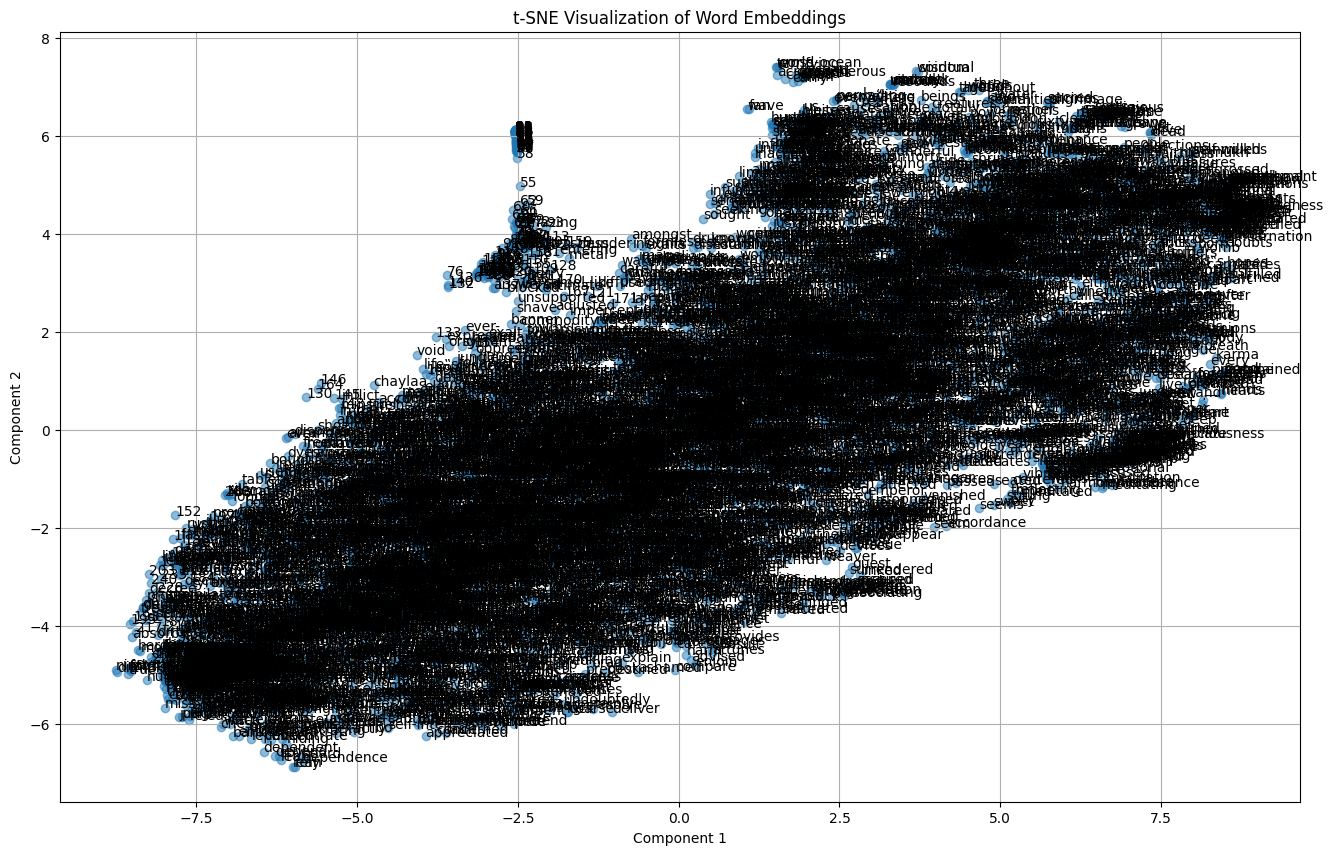

In [47]:
data_for_tsne = vocab_w2v_df.values

# Apply t-SNE transformation
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_for_tsne)

# Plot t-SNE result
plt.figure(figsize=(16, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)

# Optionally, annotate points with their labels (words)
for idx, word in enumerate(vocab_w2v_df.index):
    plt.annotate(word, (tsne_results[idx, 0], tsne_results[idx, 1]))

plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

In [28]:
# Optionally, save the result to a CSV file
doc_sent_df.to_csv('/Users/ishathukral/Downloads/DS5001project/output/doc_sent.csv', index=False)